<a href="https://colab.research.google.com/github/EmilSeyfullayev/Credit_Risk_Modeling_in_Python/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Credit Risk Modeling/train_features_selected.csv')
train.head()

,Unnamed: 0,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY_OTHER_NONE_RENT,home_ownership:MORTGAGE,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,addr_state:NE_IA_NV_AL_NM,addr_state:HI_MO_VA,addr_state:OK_TN_NJ_NC_KY,addr_state:MD_UT_LA_MN_MI,addr_state:SD_WA_AZ_OH_PA_MA_AR_DE_IN_GA,addr_state:WI_RI_OR,addr_state:CT_IL,addr_state:MT_KS_CO_SC_AK,addr_state:VT_MS_NH_WV_WY_DC_ME_ID,addr_state:FL,addr_state:CA,addr_state:NY,addr_state:TX,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,since_issue_date:<87,since_issue_date:<90,since_issue_date:<92,...,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_rec:Missing,mths_since_last_rec:0-2,mths_since_last_rec:3-20,mths_since_last_rec:21-31,mths_since_last_rec:32-48,mths_since_last_rec:49-60,mths_since_last_rec:61-84,mths_since_last_rec:84-99,mths_since_last_rec:>100,since_issue_date:<87.1,since_issue_date:<90.1,since_issue_date:<92.1,since_issue_date:<94.1,since_issue_date:<99.1,since_issue_date:<103.1,since_issue_date:<112.1,since_issue_date:<142.1,since_issue_date:>=142.1,term: 36 months,term: 60 months,good_loan
0,161569,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
1,287448,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,410266,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,453319,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
4,287547,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1


In [3]:
test = pd.read_csv("/content/drive/MyDrive/Credit Risk Modeling/test_features_selected.csv")

In [4]:
test.head()

,Unnamed: 0,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY_OTHER_NONE_RENT,home_ownership:MORTGAGE,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,addr_state:NE_IA_NV_AL_NM,addr_state:HI_MO_VA,addr_state:OK_TN_NJ_NC_KY,addr_state:MD_UT_LA_MN_MI,addr_state:SD_WA_AZ_OH_PA_MA_AR_DE_IN_GA,addr_state:WI_RI_OR,addr_state:CT_IL,addr_state:MT_KS_CO_SC_AK,addr_state:VT_MS_NH_WV_WY_DC_ME_ID,addr_state:FL,addr_state:CA,addr_state:NY,addr_state:TX,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,since_issue_date:<87,since_issue_date:<90,since_issue_date:<92,...,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_rec:Missing,mths_since_last_rec:0-2,mths_since_last_rec:3-20,mths_since_last_rec:21-31,mths_since_last_rec:32-48,mths_since_last_rec:49-60,mths_since_last_rec:61-84,mths_since_last_rec:84-99,mths_since_last_rec:>100,since_issue_date:<87.1,since_issue_date:<90.1,since_issue_date:<92.1,since_issue_date:<94.1,since_issue_date:<99.1,since_issue_date:<103.1,since_issue_date:<112.1,since_issue_date:<142.1,since_issue_date:>=142.1,term: 36 months,term: 60 months,good_loan
0,362514,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,288564,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
2,213591,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
3,263083,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
4,165001,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1


In [5]:
columns_needed_to_be_dropped = ['Unnamed: 0','since_issue_date:<87',
'since_issue_date:<90', 'since_issue_date:<92',
'since_issue_date:<94', 'since_issue_date:<99',
'since_issue_date:<103', 'since_issue_date:<112',
'since_issue_date:<142', 'since_issue_date:>=142',]

In [6]:
train.drop(columns_needed_to_be_dropped, axis=1, inplace=True)
test.drop(columns_needed_to_be_dropped, axis=1, inplace=True)

In [7]:
# test.columns == train.columns

In [8]:
#train.columns.values

reference_variables = [
'grade:G',
'verification_status:Verified',
'addr_state:NE_IA_NV_AL_NM',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term: 60 months',
'emp_length:0',
'since_issue_date:>=142.1',
'interest_rate:>20.281',
'earl_cr_line:>=437',
'delinq_2yrs:>=12',
'inq_last_6mths:>6',
'open_acc:0',
'pub_rec:0',
'total_acc:<=3',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_rec:0-2'
]

In [9]:
chp_train = train
chp_test = test
train.drop(reference_variables, axis=1, inplace=True)
test.drop(reference_variables, axis=1, inplace=True)

### Modeling

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [11]:
X_train = train.drop('good_loan', axis=1)
y_train = train['good_loan']
X_test = test.drop('good_loan', axis=1)
y_test = test['good_loan']

In [12]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [13]:
lg = LogisticRegression_with_p_values()

In [14]:
lg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [15]:
intercept = lg.intercept_
coefficients = lg.coef_

In [16]:
summary_table = pd.DataFrame()
summary_table['feature_name'] = np.array(['intercept'])
summary_table['coefficients'] = intercept
summary_table

,feature_name,coefficients
0,intercept,-1.030944


In [17]:
temp = pd.DataFrame()
temp['feature_name'] = np.array(X_train.columns.values)
temp['coefficients'] = np.array(coefficients[0]) # coefs were in [[]], so we accessed first 
temp

,feature_name,coefficients
0,grade:A,1.226570
1,grade:B,0.971279
2,grade:C,0.771589
3,grade:D,0.571721
4,grade:E,0.377744
...,...,...
109,since_issue_date:<99.1,0.680283
110,since_issue_date:<103.1,0.502187
111,since_issue_date:<112.1,0.245830
112,since_issue_date:<142.1,-0.069288


In [18]:
summary_table = pd.concat([summary_table, temp])
summary_table.reset_index(inplace=True)

In [19]:
summary_table

,index,feature_name,coefficients
0,0,intercept,-1.030944
1,0,grade:A,1.226570
2,1,grade:B,0.971279
3,2,grade:C,0.771589
4,3,grade:D,0.571721
...,...,...,...
110,109,since_issue_date:<99.1,0.680283
111,110,since_issue_date:<103.1,0.502187
112,111,since_issue_date:<112.1,0.245830
113,112,since_issue_date:<142.1,-0.069288


In [20]:
splitted_column_names = summary_table['feature_name'].apply(lambda x: str(x).split(":"))

In [21]:
main_name_of_var = []

for i in splitted_column_names:
  main_name_of_var.append(i[0])

summary_table['main_name_of_var'] = main_name_of_var
summary_table = summary_table[['main_name_of_var', 'feature_name', 'coefficients']]
summary_table

,main_name_of_var,feature_name,coefficients
0,intercept,intercept,-1.030944
1,grade,grade:A,1.226570
2,grade,grade:B,0.971279
3,grade,grade:C,0.771589
4,grade,grade:D,0.571721
...,...,...,...
110,since_issue_date,since_issue_date:<99.1,0.680283
111,since_issue_date,since_issue_date:<103.1,0.502187
112,since_issue_date,since_issue_date:<112.1,0.245830
113,since_issue_date,since_issue_date:<142.1,-0.069288


In [22]:
# plt.figure(dpi = 200)
# plt.matshow(train.corr())

In [23]:
# plt.figure(dpi = 200)
# corr = train.corr()
# corr.style.background_gradient(cmap='coolwarm') # finally found why we had SingularMatrixError

In [24]:
p_values = lg.p_values
print(len(p_values))
p_values[:5]

114


[8.287659143816337e-29,
 3.8771007789954185e-41,
 9.10379004736922e-33,
 1.3046935080417496e-20,
 5.6354533107751754e-12]

In [25]:
p_values.insert(0, np.nan)

In [26]:
print(len(p_values))
p_values[:5]

115


[nan,
 8.287659143816337e-29,
 3.8771007789954185e-41,
 9.10379004736922e-33,
 1.3046935080417496e-20]

In [27]:
summary_table['p_values'] = p_values

In [28]:
summary_table

,main_name_of_var,feature_name,coefficients,p_values
0,intercept,intercept,-1.030944,NaN
1,grade,grade:A,1.226570,8.287659e-29
2,grade,grade:B,0.971279,3.877101e-41
3,grade,grade:C,0.771589,9.103790e-33
4,grade,grade:D,0.571721,1.304694e-20
...,...,...,...,...
110,since_issue_date,since_issue_date:<99.1,0.680283,2.527976e-59
111,since_issue_date,since_issue_date:<103.1,0.502187,8.406129e-32
112,since_issue_date,since_issue_date:<112.1,0.245830,3.868279e-09
113,since_issue_date,since_issue_date:<142.1,-0.069288,7.553761e-02


In [29]:
summary_table[summary_table['p_values']>0.05]

,main_name_of_var,feature_name,coefficients,p_values
8,home_ownership,home_ownership:MORTGAGE,0.017376,0.459044
10,verification_status,verification_status:Source Verified,-0.010333,0.509042
11,purpose,purpose:oth__med__vacation,-0.007892,0.737496
14,addr_state,addr_state:HI_MO_VA,0.071737,0.087014
15,addr_state,addr_state:OK_TN_NJ_NC_KY,0.065608,0.083332
22,addr_state,addr_state:FL,0.021266,0.591711
23,addr_state,addr_state:CA,0.058997,0.103662
38,earl_cr_line,earl_cr_line:285-323,-0.028525,0.331939
39,earl_cr_line,earl_cr_line:323-380,0.048189,0.110369
40,earl_cr_line,earl_cr_line:380-437,0.018137,0.590637


In [30]:
vars_not_significant = []

for index, value in enumerate(summary_table['p_values']):
  if value>0.05:
    vars_not_significant.append(summary_table.iloc[index]['main_name_of_var'])

insignificant_vars = pd.Series(vars_not_significant).value_counts().reset_index()
insignificant_vars

,index,0
0,open_acc,7
1,total_acc,7
2,dti,7
3,mths_since_last_rec,5
4,addr_state,4
5,delinq_2yrs,3
6,earl_cr_line,3
7,annual_inc,2
8,pub_rec,2
9,total_rev_hi_lim,1


In [31]:
count_of_main_vars = summary_table['main_name_of_var'].value_counts().reset_index()
count_of_main_vars_needed = count_of_main_vars[count_of_main_vars['index'].isin(list(insignificant_vars['index']))]

In [32]:
count_of_main_vars_needed

,index,main_name_of_var
0,addr_state,12
1,annual_inc,11
2,dti,9
3,total_rev_hi_lim,8
4,open_acc,8
5,mths_since_last_rec,8
6,since_issue_date,8
7,total_acc,7
11,earl_cr_line,5
12,mths_since_last_delinq,4


In [33]:
insignificant_vars['index'] = pd.Categorical(insignificant_vars['index'], ordered=True, 
                                             categories = count_of_main_vars_needed['index'])

In [34]:
count_of_main_vars_needed['index'] = pd.Categorical(count_of_main_vars_needed['index'], ordered=True,
                                                    categories = count_of_main_vars_needed['index'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
count_of_main_vars_needed.reset_index(drop=True, inplace=True)

In [36]:
insignificant_vars = insignificant_vars.sort_values("index").reset_index(drop=True)

In [37]:
insignificant_vars

,index,0
0,addr_state,4
1,annual_inc,2
2,dti,7
3,total_rev_hi_lim,1
4,open_acc,7
5,mths_since_last_rec,5
6,since_issue_date,1
7,total_acc,7
8,earl_cr_line,3
9,mths_since_last_delinq,1


In [38]:
count_of_main_vars_needed = count_of_main_vars_needed.sort_values("index")

In [39]:
count_of_main_vars_needed

,index,main_name_of_var
0,addr_state,12
1,annual_inc,11
2,dti,9
3,total_rev_hi_lim,8
4,open_acc,8
5,mths_since_last_rec,8
6,since_issue_date,8
7,total_acc,7
8,earl_cr_line,5
9,mths_since_last_delinq,4


In [40]:
temp_p_values = pd.concat([insignificant_vars, count_of_main_vars_needed], axis=1)
temp_p_values.columns.values[1] = 'count_of_insignificant'
temp_p_values['proportion_of_insignificant'] = round(
    temp_p_values['count_of_insignificant']/temp_p_values['main_name_of_var']*100
)
temp_p_values.columns.values[3] = 'count_of_main_var'

temp_p_values = temp_p_values[['index', 'count_of_insignificant','count_of_main_var','proportion_of_insignificant']]
temp_p_values = temp_p_values.iloc[:, 1:]
temp_p_values.sort_values('proportion_of_insignificant', ascending=False)

,index,count_of_insignificant,count_of_main_var,proportion_of_insignificant
7,total_acc,7,7,100.0
11,delinq_2yrs,3,3,100.0
15,acc_now_delinq,1,1,100.0
4,open_acc,7,8,88.0
2,dti,7,9,78.0
10,pub_rec,2,3,67.0
5,mths_since_last_rec,5,8,62.0
8,earl_cr_line,3,5,60.0
12,verification_status,1,2,50.0
13,home_ownership,1,2,50.0


In [41]:
shall_be_dropped_considering_p_p_value = list(
    temp_p_values[temp_p_values['proportion_of_insignificant'] > 85]['index']
)
shall_be_dropped_considering_p_p_value
# ['open_acc', 'total_acc', 'delinq_2yrs', 'acc_now_delinq']

['open_acc', 'total_acc', 'delinq_2yrs', 'acc_now_delinq']

In [42]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# # #Selecting the Best important features according to Logistic Regression
# rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select = 71, step = 1)
# rfe_selector.fit(X_train, y_train)
# columns = X_train.columns[rfe_selector.get_support()]
# columns

# Index(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
#        'home_ownership:ANY_OTHER_NONE_RENT',
#        'verification_status:Not Verified',
#        'addr_state:SD_WA_AZ_OH_PA_MA_AR_DE_IN_GA', 'addr_state:WI_RI_OR',
#        'addr_state:CT_IL', 'addr_state:MT_KS_CO_SC_AK',
#        'addr_state:VT_MS_NH_WV_WY_DC_ME_ID', 'addr_state:TX', 'emp_length:1',
#        'emp_length:2-4', 'emp_length:5-6', 'emp_length:7-9', 'emp_length:10',
#        'interest_rate:<9.548', 'interest_rate:9.548-12.025',
#        'interest_rate:12.025-14.089', 'interest_rate:14.089-15.74',
#        'interest_rate:15.74-20.281', 'earl_cr_line:323-380',
#        'delinq_2yrs:4-11', 'inq_last_6mths:0', 'inq_last_6mths:1-2',
#        'inq_last_6mths:3-6', 'open_acc:1-3', 'pub_rec:1-2', 'pub_rec:3-5',
#        'pub_rec:>=6', 'total_acc:64-78', 'acc_now_delinq:>=1',
#        'total_rev_hi_lim:>95K', 'annual_inc:20K-30K', 'annual_inc:40K-50K',
#        'annual_inc:50K-60K', 'annual_inc:60K-70K', 'annual_inc:70K-80K',
#        'annual_inc:80K-90K', 'annual_inc:90K-100K', 'annual_inc:100K-120K',
#        'annual_inc:120K-140K', 'annual_inc:>140K',
#        'mths_since_last_delinq:Missing', 'mths_since_last_delinq:4-30',
#        'mths_since_last_delinq:31-56', 'mths_since_last_delinq:>=57',
#        'dti:1.4-3.5', 'dti:3.5-7.7', 'dti:7.7-10.5', 'dti:10.5-16.1',
#        'dti:16.1-20.3', 'dti:20.3-21.7', 'mths_since_last_rec:Missing',
#        'mths_since_last_rec:3-20', 'mths_since_last_rec:21-31',
#        'mths_since_last_rec:32-48', 'mths_since_last_rec:49-60',
#        'mths_since_last_rec:61-84', 'mths_since_last_rec:>100',
#        'since_issue_date:<87.1', 'since_issue_date:<90.1',
#        'since_issue_date:<92.1', 'since_issue_date:<94.1',
#        'since_issue_date:<99.1', 'since_issue_date:<103.1',
#        'since_issue_date:<112.1', 'since_issue_date:<142.1'],
#       dtype='object')

In [43]:
# import statsmodels.api as sm
# x_sm_logit = sm.add_constant(X_train)
# sm_logit = sm.Logit(y_train, x_sm_logit)
# results_logit = sm_logit.fit()
# results_logit.summary()

In [44]:
feautures_final = list(
      summary_table[
                ~summary_table['main_name_of_var'].isin(shall_be_dropped_considering_p_p_value)
  ]['feature_name'].iloc[1:]
)

In [45]:
X_train = X_train[feautures_final]
X_test = X_test[feautures_final]

In [46]:
X_train.shape

(312410, 95)

In [47]:
lg2 = LogisticRegression_with_p_values()
lg2.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [48]:
intercept = lg2.intercept_
coefficients = lg2.coef_
summary_table = pd.DataFrame()
summary_table['feature_name'] = np.array(['intercept'])
summary_table['coefficients'] = intercept

temp = pd.DataFrame()
temp['feature_name'] = np.array(X_train.columns.values)
temp['coefficients'] = np.array(coefficients[0]) # coefs were in [[]], so we accessed first 

summary_table = pd.concat([summary_table, temp])
summary_table.reset_index(inplace=True)

splitted_column_names = summary_table['feature_name'].apply(lambda x: str(x).split(":"))

main_name_of_var = []

for i in splitted_column_names:
  main_name_of_var.append(i[0])

summary_table['main_name_of_var'] = main_name_of_var
summary_table = summary_table[['main_name_of_var', 'feature_name', 'coefficients']]
summary_table

p_val = lg2.p_values

p_val.insert(0, np.nan)

summary_table['p_values'] = p_val

summary_table

,main_name_of_var,feature_name,coefficients,p_values
0,intercept,intercept,-1.107269,NaN
1,grade,grade:A,1.199206,1.225368e-27
2,grade,grade:B,0.960957,1.123348e-40
3,grade,grade:C,0.767240,7.081904e-33
4,grade,grade:D,0.570963,5.847956e-21
...,...,...,...,...
91,since_issue_date,since_issue_date:<99.1,0.686175,9.108250e-61
92,since_issue_date,since_issue_date:<103.1,0.508828,8.116011e-33
93,since_issue_date,since_issue_date:<112.1,0.253833,1.049014e-09
94,since_issue_date,since_issue_date:<142.1,-0.063938,1.000279e-01


In [49]:
summary_table[summary_table['p_values'] > 0.05]

,main_name_of_var,feature_name,coefficients,p_values
8,home_ownership,home_ownership:MORTGAGE,0.012288,0.598927
10,verification_status,verification_status:Source Verified,-0.009455,0.545348
11,purpose,purpose:oth__med__vacation,-0.006576,0.779880
14,addr_state,addr_state:HI_MO_VA,0.078974,0.057079
15,addr_state,addr_state:OK_TN_NJ_NC_KY,0.071085,0.057497
22,addr_state,addr_state:FL,0.028247,0.471242
23,addr_state,addr_state:CA,0.067683,0.058821
38,earl_cr_line,earl_cr_line:285-323,-0.026513,0.364406
39,earl_cr_line,earl_cr_line:323-380,0.048996,0.102574
40,earl_cr_line,earl_cr_line:380-437,0.017333,0.605410


### Evaluation

In [50]:
ch_lg = lg
lg = lg2

In [51]:
probabilities_of_predictions = lg.model.predict_proba(X_test)

In [52]:
probabilities_of_predictions = probabilities_of_predictions[:][:, 1]

In [53]:
probabilities_of_train = lg.model.predict_proba(X_train)[:][:, 1]

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score

In [55]:
probabilities_of_predictions

array([0.9385301 , 0.88423111, 0.89646522, ..., 0.98120936, 0.94470604,
       0.96483041])

In [56]:
fpr, tpr, thresholds = roc_curve(
    y_test, probabilities_of_predictions
)

Text(0.5, 1.0, 'ROC curve')

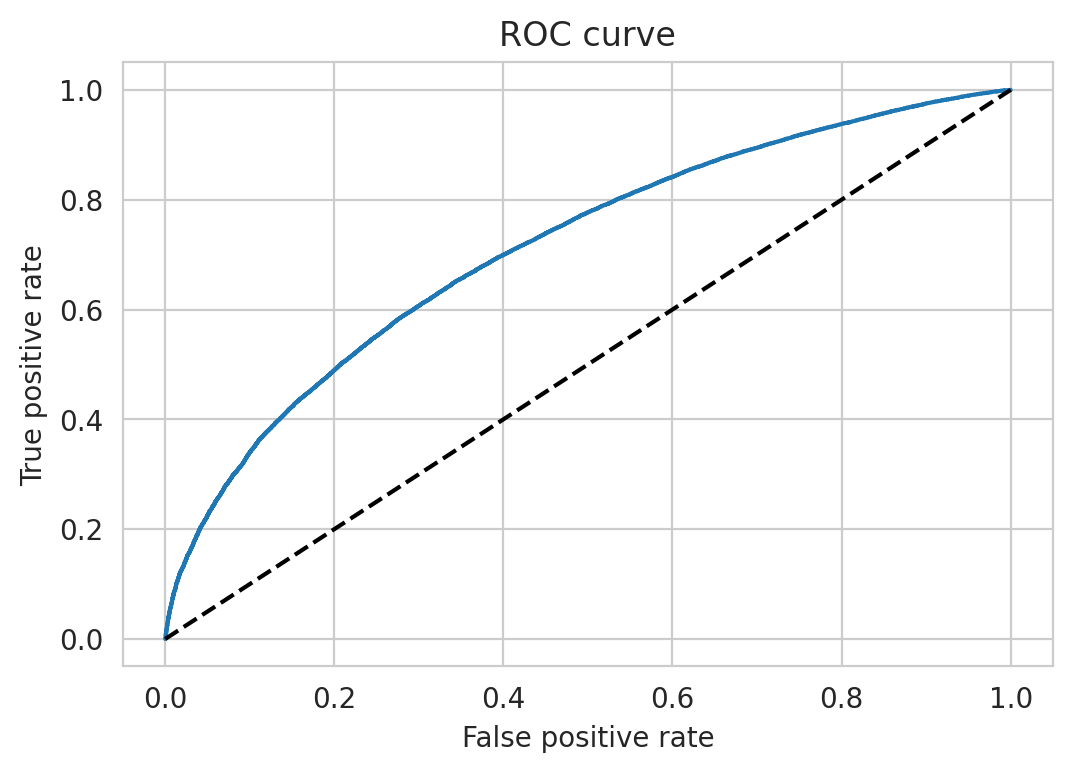

In [57]:
plt.figure(dpi=200)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [58]:
AUROC = roc_auc_score(y_test, probabilities_of_predictions)
AUROC

0.7118719697934786

In [59]:
temp = pd.DataFrame()

In [60]:
temp['tpr'] = tpr
temp['fpr'] = fpr
temp['treshold'] = thresholds

In [64]:
del(temp)

In [65]:
temp = pd.DataFrame()
temp['true'] = y_test
temp['predictions'] = probabilities_of_predictions

In [66]:
temp

,true,predictions
0,1,0.938530
1,1,0.884231
2,1,0.896465
3,1,0.958445
4,1,0.972635
...,...,...
153870,1,0.733989
153871,1,0.899310
153872,1,0.981209
153873,1,0.944706


In [67]:
# f1_scores = []

# for treshold in thresholds:

#   temp['thresholded_predictions'] = temp['predictions'].apply(lambda x: 1 if x > treshold else 0)
#   true_positive =  len(temp[
#                         (temp['true'] == 1) &
#                         (temp['thresholded_predictions'] == 1) 
#   ])
#   false_positive = len(temp[
#                         (temp['true'] == 0) &
#                         (temp['thresholded_predictions'] == 1) 
#   ])
#   false_negative =  len(temp[
#                         (temp['true'] == 1) &
#                         (temp['thresholded_predictions'] == 0) 
#   ])

#   try:

#     precision = true_positive/(true_positive+false_positive)
#     recall = true_positive/(true_positive+false_negative)

#     f1_score = 2*precision*recall/(precision+recall)
#     f1_scores.append(f1_score)
  
#   except ZeroDivisionError:
#     f1_scores.append(0) 



In [68]:
# temp2 = pd.DataFrame()
# temp2['tresholds'] = thresholds
# temp2['f1_scores'] = f1_scores
# temp2[temp2['f1_scores'] == max(temp2['f1_scores'])] # 0,4931

In [69]:
temp['0.4931_thresholded'] = temp['predictions'].apply(lambda x: 1 if x > 0.4931 else 0)

In [70]:
temp['0.5_thresholded'] = temp['predictions'].apply(lambda x: 1 if x > 0.5 else 0)

In [71]:
temp['0.9_thresholded'] = temp['predictions'].apply(lambda x: 1 if x > 0.9 else 0)

In [72]:
pd.crosstab(temp['true'], temp[ '0.4931_thresholded'])

0.4931_thresholded,0,1
true,,
0,10,15046
1,6,138813


In [73]:
pd.crosstab(temp['true'], temp[ '0.9_thresholded'])

0.9_thresholded,0,1
true,,
0,9895,5161
1,48575,90244


In [74]:
pd.Series(y_test).value_counts()

1    138819
0     15056
Name: good_loan, dtype: int64

In [75]:
from sklearn.metrics import accuracy_score , classification_report

In [76]:
print(classification_report(temp['true'], temp[ '0.4931_thresholded']))

              precision    recall  f1-score   support

           0       0.62      0.00      0.00     15056
           1       0.90      1.00      0.95    138819

    accuracy                           0.90    153875
   macro avg       0.76      0.50      0.47    153875
weighted avg       0.88      0.90      0.86    153875



In [77]:
temp

,true,predictions,0.4931_thresholded,0.5_thresholded,0.9_thresholded
0,1,0.938530,1,1,1
1,1,0.884231,1,1,0
2,1,0.896465,1,1,0
3,1,0.958445,1,1,1
4,1,0.972635,1,1,1
...,...,...,...,...,...
153870,1,0.733989,1,1,0
153871,1,0.899310,1,1,0
153872,1,0.981209,1,1,1
153873,1,0.944706,1,1,1


In [78]:
pd.crosstab(temp['true'], 
             temp['0.5_thresholded'], 
             rownames = ['Actual'], colnames = ['Predicted'])#/temp.shape[0]

Predicted,0,1
Actual,,
0,11,15045
1,11,138808


In [79]:
pd.crosstab(temp['true'], 
             temp['0.9_thresholded'], 
             rownames = ['Actual'], colnames = ['Predicted'])#/temp.shape[0]

Predicted,0,1
Actual,,
0,9895,5161
1,48575,90244


In [80]:
temp.shape[0]

153875

In [81]:
(pd.crosstab(temp['true'], 
             temp['0.5_thresholded'], 
             rownames = ['Actual'], colnames = ['Predicted']) / temp.shape[0]).iloc[0, 0] + (pd.crosstab(temp['true'], 
                          temp['0.5_thresholded'], rownames = ['Actual'], 
                          colnames = ['Predicted']) / temp.shape[0]).iloc[1, 1] # Accuracy with 0.5 threshold

0.9021543460601137

In [82]:
(pd.crosstab(temp['true'], 
             temp['0.9_thresholded'], 
             rownames = ['Actual'], colnames = ['Predicted']) / temp.shape[0]).iloc[0, 0] + (pd.crosstab(temp['true'], 
                          temp['0.9_thresholded'], rownames = ['Actual'], 
                          colnames = ['Predicted']) / temp.shape[0]).iloc[1, 1] # Accuracy with 0.9 threshold

0.6507814784727863

In [83]:
import pickle

In [84]:
filename = 'finalized_model.sav'
pickle.dump(lg, open(filename, 'wb'))

In [85]:
loaded_model = pickle.load(open(filename, 'rb'))

In [86]:
loaded_model.model.predict(np.array(X_test.iloc[0]).reshape(1,-1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


array([1])

In [87]:
loaded_model.model.predict(X_test.iloc[0:1])

array([1])

### Gini score

In [90]:
temp = temp.sort_values(by='predictions').reset_index()
temp

,index,true,predictions,0.4931_thresholded,0.5_thresholded,0.9_thresholded
0,14868,1,0.359259,0,0,0
1,99433,0,0.404460,0,0,0
2,58288,1,0.427994,0,0,0
3,95621,0,0.429274,0,0,0
4,48752,0,0.447214,0,0,0
...,...,...,...,...,...,...
153870,147683,1,0.994519,1,1,1
153871,50101,1,0.994565,1,1,1
153872,23536,1,0.994684,1,1,1
153873,136477,0,0.994899,1,1,1


In [91]:
temp['Cumulative All'] = temp.index + 1
temp['Cumulative Good'] = temp['true'].cumsum()
temp['Bad loans'] = np.where(temp['true']==0, 1, 0)
temp['Cumulative Bad'] = temp['Bad loans'].cumsum()
temp

,index,true,predictions,0.4931_thresholded,0.5_thresholded,0.9_thresholded,Cumulative All,Cumulative Good,Bad loans,Cumulative Bad
0,14868,1,0.359259,0,0,0,1,1,0,0
1,99433,0,0.404460,0,0,0,2,1,1,1
2,58288,1,0.427994,0,0,0,3,2,0,1
3,95621,0,0.429274,0,0,0,4,2,1,2
4,48752,0,0.447214,0,0,0,5,2,1,3
...,...,...,...,...,...,...,...,...,...,...
153870,147683,1,0.994519,1,1,1,153871,138816,0,15055
153871,50101,1,0.994565,1,1,1,153872,138817,0,15055
153872,23536,1,0.994684,1,1,1,153873,138818,0,15055
153873,136477,0,0.994899,1,1,1,153874,138818,1,15056


In [104]:
temp['Cumulative %'] = temp['Cumulative All']/temp.shape[0]
temp['Cumulative Good %'] = temp['Cumulative Good']/temp['true'].sum()
temp['Cumulative Bad %'] = temp['Cumulative Bad']/(temp.shape[0] - 
                                                   temp['true'].sum())
temp

,index,true,predictions,0.4931_thresholded,0.5_thresholded,0.9_thresholded,Cumulative All,Cumulative Good,Bad loans,Cumulative Bad,Cumulative %,Cumulative Good %,Cumulative Bad %
0,14868,1,0.359259,0,0,0,1,1,0,0,0.000006,0.000007,0.000000
1,99433,0,0.404460,0,0,0,2,1,1,1,0.000013,0.000007,0.000066
2,58288,1,0.427994,0,0,0,3,2,0,1,0.000019,0.000014,0.000066
3,95621,0,0.429274,0,0,0,4,2,1,2,0.000026,0.000014,0.000133
4,48752,0,0.447214,0,0,0,5,2,1,3,0.000032,0.000014,0.000199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153870,147683,1,0.994519,1,1,1,153871,138816,0,15055,0.999974,0.999978,0.999934
153871,50101,1,0.994565,1,1,1,153872,138817,0,15055,0.999981,0.999986,0.999934
153872,23536,1,0.994684,1,1,1,153873,138818,0,15055,0.999987,0.999993,0.999934
153873,136477,0,0.994899,1,1,1,153874,138818,1,15056,0.999994,0.999993,1.000000


Text(0.5, 1.0, 'Gini')

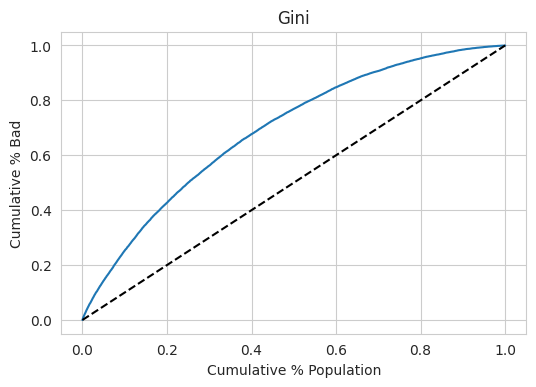

In [98]:
plt.figure(dpi=100)
plt.plot(temp['Cumulative %'], temp['Cumulative Bad %'])
plt.plot(temp['Cumulative %'], temp['Cumulative %'], linestyle = '--', color = 'k')
plt.xlabel('Cumulative % Population')
plt.ylabel('Cumulative % Bad')
plt.title('Gini')

In [99]:
Gini = AUROC * 2 - 1
Gini

0.4237439395869571

### Kolmogorov-Smirnov

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

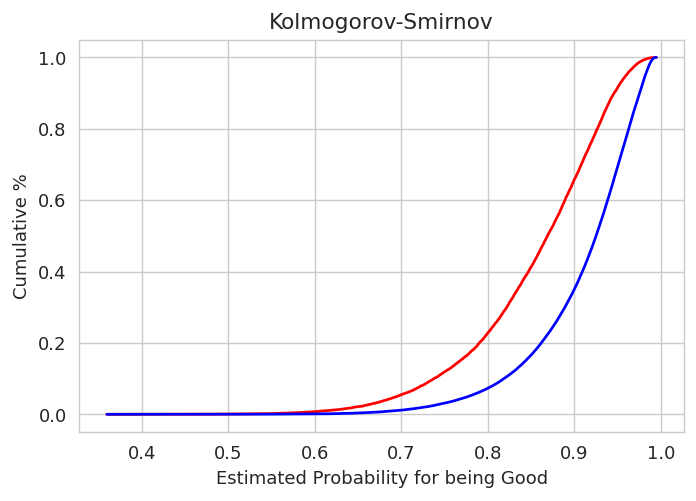

In [106]:
plt.figure(dpi=130)
plt.plot(temp['predictions'], temp['Cumulative Bad %'], color = 'r')
plt.plot(temp['predictions'], temp['Cumulative Good %'], color = 'b')
plt.xlabel('Estimated Probability for being Good')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov')

In [107]:
KS = max(temp['Cumulative Bad %'] - temp['Cumulative Good %'])
KS

0.30781512429211655